# Preprocesamiento de Datos
Cargamos las librerias necesarias para la ejecucion de la practica.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import classification_report, accuracy_score

## Procesar la base de datos
Para ello se eliminara la primera columna que no contiene información relevante para este proposito y se transformaran los tipos de datos **categoricos**

In [ ]:
def procesar_archivo_csv(archivo_csv):
    # Lee el archivo CSV
    df = pd.read_csv(archivo_csv)

    # Ignora la primera columna
    df = df.iloc[:, 1:]

    # Convierte los valores categóricos a numéricos
    le = LabelEncoder()
    df = df.apply(lambda col: le.fit_transform(col.astype(str)), axis=0)

    return df

## Tratamiento de Outliers
Estos valores son atípicos porque son inusualmente altos o bajos en comparación con la mayoría de las observaciones. La presencia de outliers puede afectar negativamente el rendimiento y la interpretación de los modelos estadísticos y de aprendizaje automático.

Trataremos los outliers por **eliminación**

In [ ]:
def eliminar_outliers(data):
    columnas_categoricas = ['Married', 'Gender', 'Education', 'SelfEmployed', 'PropertyArea', 'LoanStatus', 'Dependents']
    columnas_no_categoricas = [col for col in data.columns if col not in columnas_categoricas]
    for col in columnas_no_categoricas:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1

        # Solo conserva las filas que no son outliers
        data = data[~((data[col] < (Q1 - 20 * IQR)) | (data[col] > (Q3 + 20 * IQR)))]

    return data

## Clase balanceada
Algoritmo que permite saber si se tratan de clases balanceadas o no

In [ ]:
def es_clase_balanceada(y, umbral=0.1):
    # Calcula la frecuencia de cada clase
    conteo_clases = y.value_counts()

    # Calcula la proporción de cada clase en relación con la clase mayoritaria
    proporciones = conteo_clases / conteo_clases.max()

    # Verifica si la diferencia en las proporciones es menor al umbral
    balanceada = all(abs(proporciones - 1) < umbral)

    return balanceada

### Algoritmo SMOTE

In [ ]:
def aplicar_smote(df, target_column):
    # Divide el DataFrame en características (X) y etiquetas (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Aplica SMOTE a las características y etiquetas
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Combina las características y etiquetas resampleadas en un nuevo DataFrame
    df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name=target_column)], axis=1)

    return df_resampled

## Tratamiento de valores ausentes
Para tratar los valores nulos o valores ausentes he escogido la tecnica de **k-Means Clustering Imputation** en esta estrategia, las observaciones se agrupan en clústeres utilizando el algoritmo k-means. Luego, los valores ausentes se imputan utilizando la media o mediana del clúster al que pertenece la observación. Puede ser útil cuando hay patrones estructurados en los datos.

Explicare brevemente en consisten las demas técnicas.

1. **Valor Más Común en el Concepto (Most Common Value in Concept):** Similar a la estrategia anterior, pero aquí se considera el valor más común dentro de un subconjunto específico o concepto relacionado con la observación que tiene el valor faltante. Puede ser útil en situaciones donde la variabilidad de los datos es alta.
2. **k-Nearest Neighbor Imputation (kNNI):** Esta técnica utiliza la información de las observaciones más cercanas (vecinos más cercanos) para imputar el valor faltante. Se calcula la similitud entre observaciones y se asigna el valor basándose en los k vecinos más cercanos. Es eficaz para datos continuos y puede preservar patrones más complejos.
3. **Valor Más Común (Most Common Value):** En esta técnica, los valores ausentes se llenan con el valor más frecuente presente en la variable correspondiente. Es una opción sencilla y rápida, adecuada cuando la variable es categórica o discreta.


### Eliminación de valores ausentes

In [ ]:
def eliminar_filas_nulas(df):
    # Elimina las filas con valores nulos
    df_sin_nulos = df.dropna()

    return df_sin_nulos

### k-Means Clustering Imputation

In [ ]:
def imputar_kmeans(df, n_clusters=5):
    # Encuentra los clusters usando K-Means
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(df.dropna())

    # Asigna el cluster a cada fila con valor nulo
    df_imputado = df.copy()
    df_imputado[df.isnull()] = kmeans.cluster_centers_[kmeans.predict(df.isnull().astype(int))]

    return df_imputado

## Ejecución



In [ ]:
# Ejemplo de uso
archivo_csv = 'datos.csv'
df_original = procesar_archivo_csv(archivo_csv)

### Tratando los datos

In [ ]:
# Selecciona la columna de etiquetas (ajusta según tus necesidades)
loanStatus = df_original['LoanStatus']

# Verifica si la clase está balanceada
balanceada = es_clase_balanceada(loanStatus)

if balanceada:
    print("La clase está balanceada.")
else:
    print("La clase no está balanceada.")

# Tratar outliers
df_tratado = eliminar_outliers(df_original)

# Imputar valores nulos mediante K-Means
df_imputado_kmeans = imputar_kmeans(df_tratado)

# Aplicar SMOTE al DataFrame
variable = 'LoanStatus'
df_resampled = aplicar_smote(df_imputado_kmeans, variable)

La clase no está balanceada.


### Sin tratar los datos

In [ ]:
# Eliminar filas con valores nulos
df_sin_nulos = eliminar_filas_nulas(df_original)

# Calsificadores

Los clasificadores son algoritmos que se utilizan para asignar categorías o etiquetas a datos no etiquetados basándose en patrones aprendidos a partir de datos previamente etiquetados.

## Preparación


In [ ]:
def preparar_datos(df, target_column):
    # Divide el DataFrame en características (X) y etiquetas (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Divide los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

## Clasificador k-NN

In [ ]:
def construir_knn(X_train, y_train, n_neighbors=3):
    # Construye el clasificador k-NN
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Ajusta el modelo al conjunto de entrenamiento
    knn_classifier.fit(X_train, y_train)

    return knn_classifier

## Clasificador Árbol de clasificación

In [ ]:
def construir_arbol_clasificacion(X_train, y_train, max_depth=None):
    # Construye el árbol de clasificación
    tree_classifier = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

    # Ajusta el modelo al conjunto de entrenamiento
    tree_classifier.fit(X_train, y_train)

    return tree_classifier

## Clasificador Naive bayes

In [ ]:
def construir_naive_bayes(X_train, y_train):
    # Construye el clasificador Naive Bayes (Gaussian)
    naive_bayes_classifier = GaussianNB()

    # Ajusta el modelo al conjunto de entrenamiento
    naive_bayes_classifier.fit(X_train, y_train)

    return naive_bayes_classifier

## Evaluar Clasificadores

In [ ]:
def imprimir_matriz_confusion(y_real, y_pred, labels=None):
    """
    Imprime la matriz de confusión.

    Parameters:
    - y_real: Etiquetas reales.
    - y_pred: Etiquetas predichas.
    - labels: Lista de etiquetas de clases. Si no se proporciona, se infiere de las etiquetas reales y predichas.
    """
    if labels is None:
        labels = sorted(set(y_real) | set(y_pred))

    matriz_confusion = confusion_matrix(y_real, y_pred, labels=labels)

    plt.figure(figsize=(len(labels), len(labels)))
    sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Matriz de Confusión')
    plt.show()

def evaluar_clasificador(clasificador, X_train, y_train, X_test, y_test, nombre_clasificador):
    # Entrenar el clasificador
    clasificador.fit(X_train, y_train)

    # Realizar predicciones
    y_pred = clasificador.predict(X_test)

    # Imprimir métricas adicionales
    print(f"\nMétricas para el clasificador {nombre_clasificador}:")
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Precisión global (accuracy): {accuracy:.4f}")

    # Imprimir la matriz de confusión
    imprimir_matriz_confusion(y_test, y_pred, labels=clasificador.classes_)


### Evaluación tratando los datos


Clasificadores para Base de Datos Tratada (preprocesada):

Métricas para el clasificador k-NN:
              precision    recall  f1-score   support

           0       0.66      0.83      0.73        69
           1       0.79      0.60      0.68        75

    accuracy                           0.71       144
   macro avg       0.72      0.71      0.71       144
weighted avg       0.73      0.71      0.71       144

Precisión global (accuracy): 0.7083


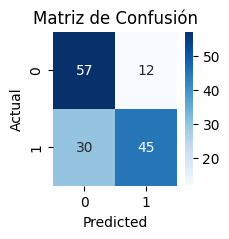


Métricas para el clasificador Árbol de Clasificación:
              precision    recall  f1-score   support

           0       0.62      0.83      0.71        69
           1       0.77      0.53      0.63        75

    accuracy                           0.67       144
   macro avg       0.69      0.68      0.67       144
weighted avg       0.70      0.67      0.67       144

Precisión global (accuracy): 0.6736


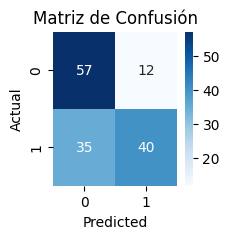


Métricas para el clasificador Naive Bayes:
              precision    recall  f1-score   support

           0       0.63      0.72      0.68        69
           1       0.71      0.61      0.66        75

    accuracy                           0.67       144
   macro avg       0.67      0.67      0.67       144
weighted avg       0.67      0.67      0.67       144

Precisión global (accuracy): 0.6667


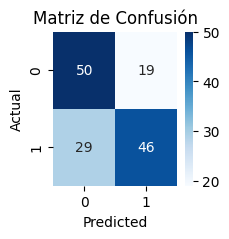

In [ ]:
# Separar características (X) y etiquetas (y)
X = df_resampled.drop('LoanStatus', axis=1)
y = df_resampled['LoanStatus']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Clasificadores para Base de Datos Tratada
print("\nClasificadores para Base de Datos Tratada (preprocesada):")

# Crear y evaluar el clasificador k-NN
knn_clasificador = KNeighborsClassifier(n_neighbors=5)
evaluar_clasificador(knn_clasificador, X_train, y_train, X_test, y_test, "k-NN")

# Crear y evaluar el árbol de clasificación
arbol_clasificador = DecisionTreeClassifier(random_state=42)
evaluar_clasificador(arbol_clasificador, X_train, y_train, X_test, y_test, "Árbol de Clasificación")

# Crear y evaluar el clasificador Naive Bayes
naive_bayes_clasificador = GaussianNB()
evaluar_clasificador(naive_bayes_clasificador, X_train, y_train, X_test, y_test, "Naive Bayes")

### Evaluación sin tratar los datos


Clasificadores para Base de Datos sin Tratar:

Métricas para el clasificador k-NN:
              precision    recall  f1-score   support

           0       0.63      0.28      0.39        43
           1       0.70      0.91      0.79        80

    accuracy                           0.69       123
   macro avg       0.67      0.60      0.59       123
weighted avg       0.68      0.69      0.65       123

Precisión global (accuracy): 0.6911


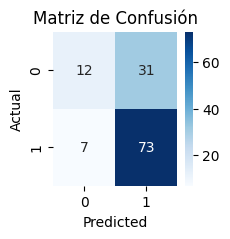


Métricas para el clasificador Árbol de Clasificación:
              precision    recall  f1-score   support

           0       0.30      0.28      0.29        43
           1       0.63      0.65      0.64        80

    accuracy                           0.52       123
   macro avg       0.46      0.46      0.46       123
weighted avg       0.51      0.52      0.52       123

Precisión global (accuracy): 0.5203


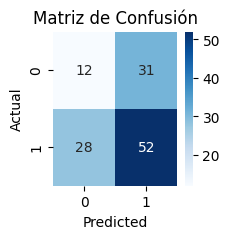


Métricas para el clasificador Naive Bayes:
              precision    recall  f1-score   support

           0       0.56      0.12      0.19        43
           1       0.67      0.95      0.78        80

    accuracy                           0.66       123
   macro avg       0.61      0.53      0.49       123
weighted avg       0.63      0.66      0.58       123

Precisión global (accuracy): 0.6585


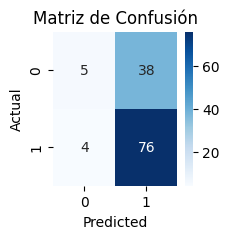

In [ ]:
# Clasificadores para Base de Datos sin Tratar
print("\nClasificadores para Base de Datos sin Tratar:")

# Separar características (X) y etiquetas (y)
X = df_sin_nulos.drop('LoanStatus', axis=1)
y = df_sin_nulos['LoanStatus']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y evaluar el clasificador k-NN
knn_clasificador = KNeighborsClassifier(n_neighbors=5)
evaluar_clasificador(knn_clasificador, X_train, y_train, X_test, y_test, "k-NN")

# Crear y evaluar el árbol de clasificación
arbol_clasificador = DecisionTreeClassifier(random_state=42)
evaluar_clasificador(arbol_clasificador, X_train, y_train, X_test, y_test, "Árbol de Clasificación")

# Crear y evaluar el clasificador Naive Bayes
naive_bayes_clasificador = GaussianNB()
evaluar_clasificador(naive_bayes_clasificador, X_train, y_train, X_test, y_test, "Naive Bayes")